<a href="https://colab.research.google.com/github/Royer511/ML-Cartpole/blob/main/cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import gym
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
import pandas as pd

In [2]:
# Create the CartPole environment
env = gym.make("CartPole-v1")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [3]:
# @title
class CartPoleAgent:
    def __init__(self, buckets=(1, 1, 6, 12),
                 learning_rate=0.1, discount_factor=0.95,
                 exploration_rate=1.0, exploration_decay_rate=0.99):
        self.buckets = buckets
        self.q_table = defaultdict(lambda: np.zeros(env.action_space.n))
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay_rate = exploration_decay_rate
        self.rewards = []
        self.episode_lengths = []
        self.training_errors = []

    def discretize(self, state):
        upper_bounds = [env.observation_space.high[0], 0.5, env.observation_space.high[2], math.radians(50)]
        lower_bounds = [env.observation_space.low[0], -0.5, env.observation_space.low[2], -math.radians(50)]
        ratios = [(state[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) for i in range(len(state))]
        new_obs = [int(round((self.buckets[i] - 1) * ratios[i])) for i in range(len(state))]
        new_obs = [min(self.buckets[i] - 1, max(0, new_obs[i])) for i in range(len(state))]
        return tuple(new_obs)

    def get_action(self, state):
        if np.random.random() < self.exploration_rate:
            return env.action_space.sample()
        else:
            return np.argmax(self.q_table[state])

    def update_q_values(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        updated_value = reward + self.discount_factor * self.q_table[next_state][best_next_action]
        self.q_table[state][action] += self.learning_rate * (updated_value - self.q_table[state][action])

    def decay_exploration_rate(self):
        self.exploration_rate *= self.exploration_decay_rate


In [4]:
agent = CartPoleAgent()
# Function to run a training session with specified hyperparameters
def train_agent(learning_rate, discount_factor, exploration_rate, exploration_decay_rate):
    agent = CartPoleAgent(learning_rate=learning_rate, discount_factor=discount_factor, exploration_rate=exploration_rate, exploration_decay_rate=exploration_decay_rate)
    n_episodes = 1000  # Number of episodes for training

    for episode in tqdm(range(n_episodes)):
        current_state = agent.discretize(env.reset())
        done = False
        episode_reward = 0
        episode_length = 0

        while not done:
            action = agent.get_action(current_state)
            next_state, reward, done, _ = env.step(action)
            episode_reward += reward
            episode_length += 1
            next_discrete_state = agent.discretize(next_state)

            agent.update_q_values(current_state, action, reward, next_discrete_state)
            current_state = next_discrete_state

        agent.decay_exploration_rate()
        agent.rewards.append(episode_reward)
        agent.episode_lengths.append(episode_length)

    return agent, agent.rewards, agent.episode_lengths  # Return performance metrics

# Hyperparameter testing
learning_rates = [0.01, 0.1, 0.5]  # Example learning rates to test
discount_factors = [0.8, 0.9, 0.99]  # Example discount factors to test

# Example structure to store results
results = []


# Loop over different hyperparameters
for lr in learning_rates:
    for df in discount_factors:
        # Train the agent with the current set of hyperparameters
        trained_agent, rewards, lengths = train_agent(learning_rate=lr, discount_factor=df, exploration_rate=1.0, exploration_decay_rate=0.99)

        # Store the results
        results.append({
            'Learning Rate': lr,
            'Discount Factor': df,
            'Rewards': rewards,
            'Lengths': lengths
        })
# Now that all agents have been trained and results are stored,
# calculate the average reward and length for each set of hyperparameters
for result in results:
    result['Average Reward'] = np.mean(result['Rewards'])
    result['Average Length'] = np.mean(result['Lengths'])

# Now 'results' contains all data needed for analysis and plotting
results_df = pd.DataFrame(results)

100%|██████████| 1000/1000 [00:12<00:00, 79.51it/s]


plotting for further analysis:
Rewards over time, Episode Length overtime and running average of episodes overtime.

**Episode Rewards:** Ideally, you'd want the rewards to increase over time, indicating that the agent is learning to make better decisions.
**Episode Lengths:** This indicates how long each episode lasts. An increasing trend might suggest the agent is improving (depending on the task).

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


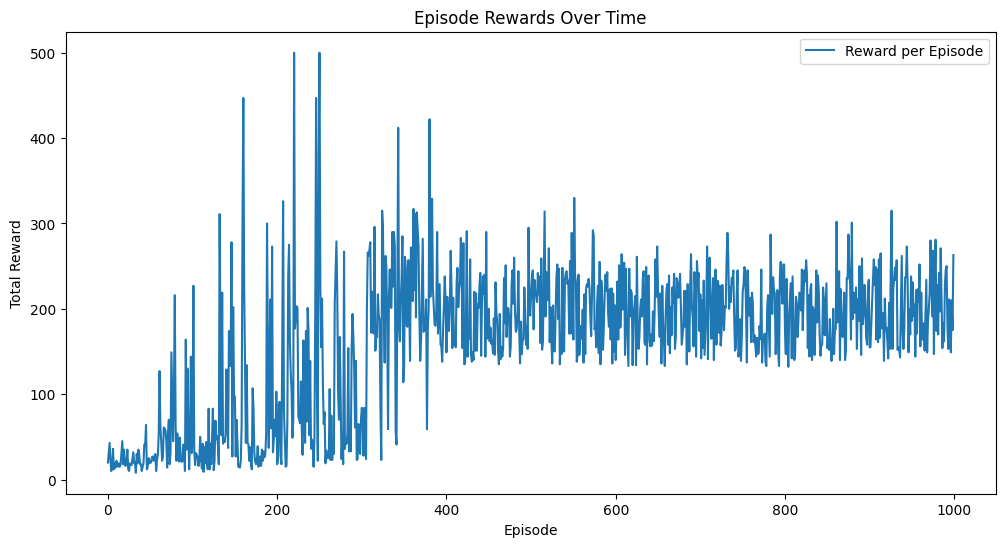

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(rewards, label='Reward per Episode')
plt.title('Episode Rewards Over Time')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

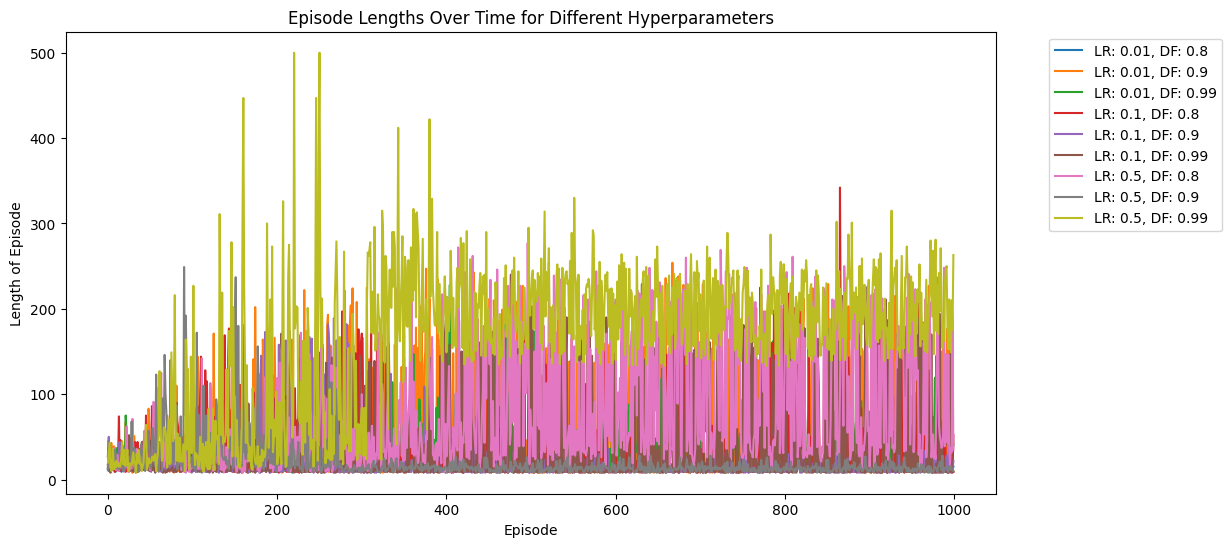

In [6]:
plt.figure(figsize=(12, 6))

# Loop over each result and plot the episode lengths
for result in results:
    plt.plot(result['Lengths'], label=f"LR: {result['Learning Rate']}, DF: {result['Discount Factor']}")

plt.title('Episode Lengths Over Time for Different Hyperparameters')
plt.xlabel('Episode')
plt.ylabel('Length of Episode')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

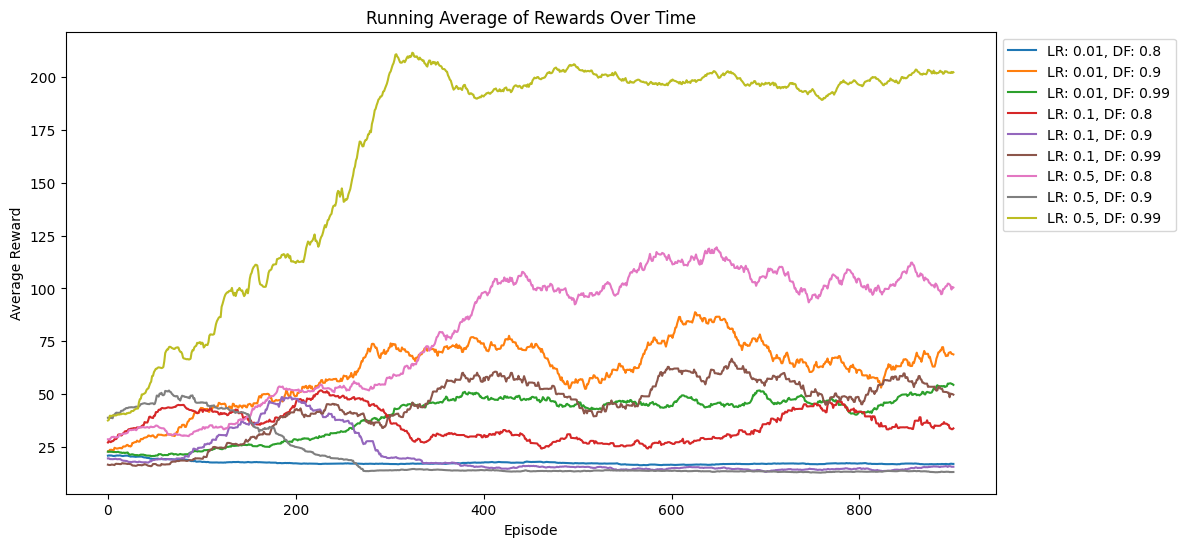

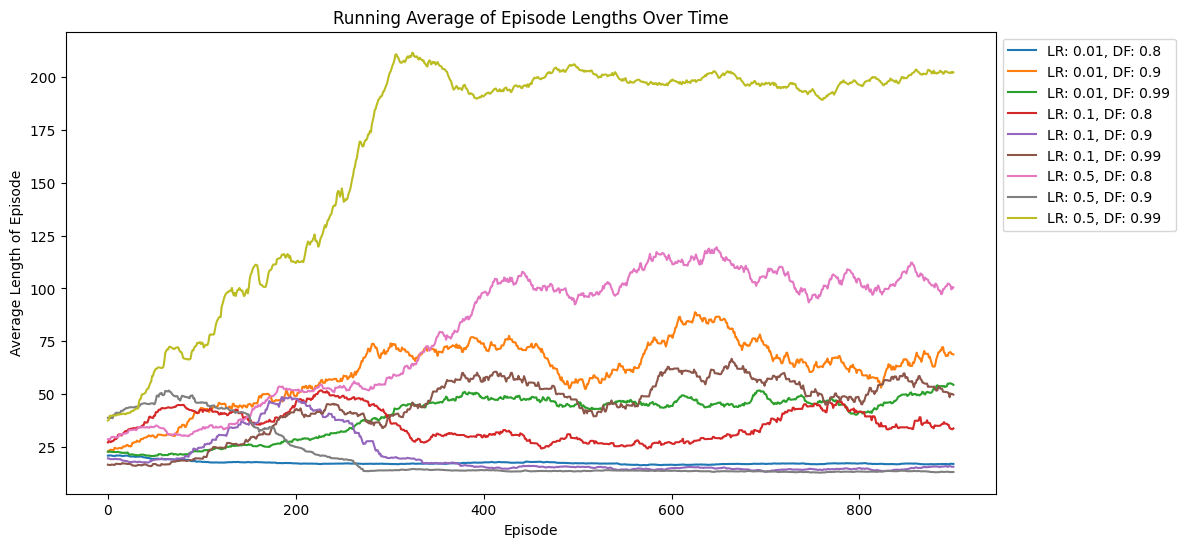

In [7]:
def running_average(data, window_size=100):
    """ Calculate the running average of the data using a window size. """
    return np.convolve(data, np.ones(window_size), 'valid') / 100

plt.figure(figsize=(12, 6))

# Plotting the running average of rewards for all hyperparameters
for result in results:
    rewards_running_avg = running_average(result['Rewards'], 100)
    plt.plot(rewards_running_avg, label=f"LR: {result['Learning Rate']}, DF: {result['Discount Factor']}")

plt.title('Running Average of Rewards Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

plt.figure(figsize=(12, 6))

# Plotting the running average of episode lengths for all hyperparameters
for result in results:
    lengths_running_avg = running_average(result['Lengths'], 100)
    plt.plot(lengths_running_avg, label=f"LR: {result['Learning Rate']}, DF: {result['Discount Factor']}")

plt.title('Running Average of Episode Lengths Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Length of Episode')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()